# Inferring citation style from the reference string
Dominika Tkaczyk

3.08.2019

This notebook contains the experiments related to inferring citation style from the reference string. The main goal is to build a supervised classifier able to classify the given reference string into one of the known styles or "unknown".

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from styleclass.settings import STYLES
from styleclass.features import get_default_training_dataset, clean_dataset, add_noise, \
    generate_unknown, tokens_to_classes, get_tfidf_features, get_features, select_features_rf, \
    select_features_chi2, get_default_test_dataset
from styleclass.classify import evaluate_cv, evaluate_model

from random import randint, seed, sample
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from statistics import mean

I am using the following 17 styles in these experiments:

In [2]:
STYLES

['acm-sig-proceedings',
 'american-chemical-society',
 'american-chemical-society-with-titles',
 'american-institute-of-physics',
 'american-sociological-association',
 'apa',
 'bmc-bioinformatics',
 'chicago-author-date',
 'elsevier-without-titles',
 'elsevier-with-titles',
 'harvard3',
 'ieee',
 'iso690-author-date-en',
 'modern-language-association',
 'springer-basic-author-date',
 'springer-lecture-notes-in-computer-science',
 'vancouver']

## Preparing the data

### Reading the data

The data for the experiments was generated automatically by formatting 5k metadata records (randomly chosen from the Crossref collection) into 17 styles. This resulted in 85k pairs (reference string, citation style name). I also keep the DOI of the metadata record used to generate the reference string.

In [3]:
dataset = get_default_training_dataset()
print('Dataset size: {}'.format(dataset.shape[0]))
dataset.head()

Dataset size: 85000


,doi,style,string
0,10.3917/rne.044.0267,acm-sig-proceedings,"[1]Lecouvey, G. et al. 2012. Les apports de la..."
1,10.3917/rne.044.0267,american-chemical-society,"(1) Lecouvey, G.; Gonneaud, J.; Eustache, F.; ..."
2,10.3917/rne.044.0267,american-chemical-society-with-titles,"(1) Lecouvey, G.; Gonneaud, J.; Eustache, F.; ..."
3,10.3917/rne.044.0267,american-institute-of-physics,"1 G. Lecouvey, J. Gonneaud, F. Eustache, and B..."
4,10.3917/rne.044.0267,american-sociological-association,"Lecouvey, Grégory, Julie Gonneaud, Francis Eus..."


Let's see example entries for each style:

In [4]:
seed(10)
examples = dataset.groupby('style').nth(randint(0, 4999)).reset_index()
print('\n\n'.join(['{}\n{}'.format(s, t) for s, t in zip(examples['style'].tolist(),
                                                         examples['string'].tolist())]))

acm-sig-proceedings
[1]2015. Frontmatter. Zeitschrift für Naturforschung C. 70, 9-10 (Sep. 2015), i–iii.

american-chemical-society
(1) Zeitschrift für Naturforschung C 2015, 70, i–iii.

american-chemical-society-with-titles
(1) Frontmatter. Zeitschrift für Naturforschung C 2015, 70, i–iii.

american-institute-of-physics
1Zeitschrift Für Naturforschung C 70, i (2015).

american-sociological-association
Anon. 2015. “Frontmatter.” Zeitschrift für Naturforschung C 70(9-10):i–iii. Retrieved (http://dx.doi.org/10.1515/znc-2015-frontmatter9-10).

apa
Frontmatter. (2015). Zeitschrift Für Naturforschung C, 70(9-10), i–iii. doi:10.1515/znc-2015-frontmatter9-10

bmc-bioinformatics
1. Frontmatter. Zeitschrift für Naturforschung C 2015, 70:i–iii.

chicago-author-date
“Frontmatter.” 2015. Zeitschrift Für Naturforschung C 70 (9-10) (September 1): i–iii. doi:10.1515/znc-2015-frontmatter9-10. http://dx.doi.org/10.1515/znc-2015-frontmatter9-10.

elsevier-with-titles
[1]Frontmatter, Zeitschrift Für Natu

### Data cleaning

First, let's get rid of null and very short reference strings. We also remove fragments like DOIs, because "real" reference strings rarely contain those and we do not want our models to rely on their presence.

In [5]:
dataset = clean_dataset(dataset)
print('Dataset size: {}'.format(dataset.shape[0]))

Dataset size: 82808


Reference strings generated automatically are also a bit too perfect. For example, all strings of american-chemical-society style are prefixed by "(1)". This prefix alone would be enough for the learning algorithm to assign a string to this style. On the other hand, we cannot expect all strings "in real life" to have a proper prefix (some tools/extractors might strip this).

Also, the strings were generated from rich metadata records, and as a result, contain fragments such as the names of the months from the publication date. In practise, however, the dates are typically given as years only ("(1997)" instead of "(Mar 1997)").

To make the dataset a bit less perfect, let's remove such fragments from some of the references (randomly chosen):

In [6]:
dataset = add_noise(dataset, random_state=0)
dataset.head()

,doi,style,string
0,10.3917/rne.044.0267,acm-sig-proceedings,"[1]Lecouvey, G. et al. 2012. Les apports de la..."
1,10.3917/rne.044.0267,american-chemical-society,"Lecouvey, G.; Gonneaud, J.; Eustache, F.; Desg..."
2,10.3917/rne.044.0267,american-chemical-society-with-titles,"(1) Lecouvey, G.; Gonneaud, J.; Eustache, F.; ..."
3,10.3917/rne.044.0267,american-institute-of-physics,"1 G. Lecouvey, J. Gonneaud, F. Eustache, and B..."
4,10.3917/rne.044.0267,american-sociological-association,"Lecouvey, Grégory, Julie Gonneaud, Francis Eus..."


Finally, we will add the "unknown" category to the dataset. The reference strings in this category will be generated by randomly swapping tokens in the "proper" reference strings.

In [7]:
dataset_unknown = generate_unknown(dataset, 5000, random_state=0)
dataset = pd.concat([dataset, dataset_unknown])
print('Dataset size: {}'.format(dataset.shape[0]))

Dataset size: 87808


## Feature representation

We will use a TF-IDF bag-of-ngrams representation of the reference strings. In this case, however, the tokens will be different from the typical use case. We will leave punctuation characters as tokens, and map the actual words into word classes such as "capitalized word", or "uppercase letter". This is done to preserve the style-related information. We will also mark the beginning and the end of the string with special tokens.

This function maps the tokens in the string into our token classes:

In [8]:
tokens_to_classes('Eberlein, T. J. Yearbook of Surgery 2006, 2006, 322–324.')

'start capword comma uclett dot uclett dot capword lcword capword year comma year comma num dash num dot end'

## The basic model

Let's now build some models and evaluate them. We will use logistic regression algorithm to predict the style from TF-IDFs of the tokens. We will use all 1-grams and 2-grams we have in the train set. We will perform a 5-fold cross-validation on the training set, and look at the resulting accuracy.

Function *get_tfidf_features* passed to the evaluation function calculates a matrix of TD-IDF features for the list of strings. It is typically called twice, first on the training set and then on the test set (in this case, it will be called twice for every cross-validation split). When called on the training set, it calculates the vocabulary and IDFs using the entire training set (this is called fitting). When called on the test set, nothing is learned from the entire test set, but we reuse the vocabulary and IDFs calculated previously on the training set.

In [9]:
logging.disable(logging.ERROR)
           
accuracies, _ = evaluate_cv(dataset, LogisticRegression(solver='liblinear', multi_class='ovr',
                                                        random_state=0),
                            feature_fun=get_tfidf_features, ngrams=(1, 2), nfeatures=None,
                            feature_selector=None, random_state=0)
print('Fold accuracies: {}'.format(accuracies))
print('Mean accuracy: {}'.format(mean(accuracies)))

Fold accuracies: [0.9126013938078373, 0.9202285714285714, 0.9193229901269393, 0.9177215189873418, 0.9198357945150807]
Mean accuracy: 0.9179420537731541


The accuracy is already decent.

## Choosing the ngram range

Let's now see how the n-gram range affects the accuracy:

In [10]:
results = np.zeros((4, 4))
for min_r in range(1, 5):
    for max_r in range(min_r, 5):
        accuracies, _ = evaluate_cv(dataset, LogisticRegression(solver='liblinear',
                                                                multi_class='ovr',
                                                                random_state=0),
                                    feature_fun=get_tfidf_features, nfeatures=None,
                                    ngrams=(min_r, max_r), feature_selector=None,
                                    random_state=0)
        results[min_r-1, max_r-1] = mean(accuracies)
        print('Accuracy for ngrams range ({}, {}): {}'.format(min_r, max_r, mean(accuracies)))

Accuracy for ngrams range (1, 1): 0.6429995565357051
Accuracy for ngrams range (1, 2): 0.9179420537731541
Accuracy for ngrams range (1, 3): 0.9404468077588604
Accuracy for ngrams range (1, 4): 0.9440585520001304
Accuracy for ngrams range (2, 2): 0.9212885625578777
Accuracy for ngrams range (2, 3): 0.9416774106975155
Accuracy for ngrams range (2, 4): 0.9447430446777196
Accuracy for ngrams range (3, 3): 0.9418369636880682
Accuracy for ngrams range (3, 4): 0.9435140323464734
Accuracy for ngrams range (4, 4): 0.9408594942671523


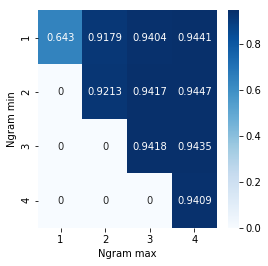

In [11]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(results, annot=True, fmt='.4g', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4],
            cmap='Blues')
plt.ylabel('Ngram min')
plt.xlabel('Ngram max')
plt.show()

Based on this, we will choose the range (2, 4).
 
Let's calculate the features for our training set and look at the most frequent n-grams:

In [12]:
count_vectorizer, _, tfidf_features = get_tfidf_features(dataset['string'],
                                                         ngrams=(2, 4))
tfidf_feature_names = count_vectorizer.get_feature_names()
print('Number of features: {}'.format(len(tfidf_feature_names)))

occurrences = count_vectorizer.fit_transform(dataset['string']).toarray().sum(axis=0)
indices = np.argsort(occurrences)[::-1]
tfidf_feature_names = np.array(tfidf_feature_names)[indices]
occurrences = np.array(occurrences)[indices]
print('\n'.join(['{}: {}'.format(p[0], p[1])
                 for p in list(zip(tfidf_feature_names, occurrences))[:50]]))

Number of features: 26306
capword capword: 263525
uclett dot: 193640
lcword lcword: 180980
capword comma: 161957
capword lcword: 156110
lcword capword: 143922
dot capword: 137731
lcword lcword lcword: 112891
capword lcword capword: 103931
comma uclett: 102487
comma uclett dot: 99111
comma capword: 88795
capword comma uclett: 85519
capword comma uclett dot: 84608
capword capword capword: 83083
lcword lcword lcword lcword: 82174
capword dot: 76268
lcword capword capword: 71577
uclett dot capword: 64104
capword capword lcword: 62644
num dash: 57399
dash num: 55514
capword lcword capword capword: 54710
dot uclett: 54285
num dash num: 52416
dot uclett dot: 50937
uclett dot uclett: 50291
capword capword lcword capword: 49723
dot capword comma: 49596
uclett dot uclett dot: 49100
uclett dot capword comma: 45323
lcword dot: 44929
dot num: 44654
comma num: 44116
dot end: 41871
num dot: 40949
start capword: 40649
capword capword dot: 40164
year rpar: 39533
num comma: 38769
num lpar: 38641
lpar ye

We can see all types of ngrams. In most cases we can guess where they came from, eg. "lcword lcword lcword lcword" is typically a fragment of the title, and "uclett dot capword comma" looks like a fragment from the authors' list.

We can also check which features are the most correlated with the styles. We will use chi-squared statistic for this:

In [13]:
for style in STYLES:
    print()
    print('Style: {}'.format(style))
    features_chi2 = chi2(tfidf_features, dataset['style'] == style)[0]
    indices = np.argsort(features_chi2)
    feature_names = np.array(count_vectorizer.get_feature_names())[indices]
    bigrams = [v for v in feature_names if len(v.split(' '))  == 2]
    trigrams = [v for v in feature_names if len(v.split(' '))  == 3]
    fourgrams = [v for v in feature_names if len(v.split(' '))  == 4]
    print('Most correlated bigrams: {}'.format('|'.join(bigrams[-5:])))
    print('Most correlated trigrams: {}'.format('|'.join(trigrams[-5:])))
    print('Most correlated fourgrams: {}'.format('|'.join(fourgrams[-5:])))


Style: acm-sig-proceedings
Most correlated bigrams: dot lcword|dot year|rbracket year|rpar comma|rbracket capword
Most correlated trigrams: uclett dot year|num rbracket capword|rpar comma num|rbracket capword comma|year rpar comma
Most correlated fourgrams: num rbracket capword comma|dot year dot capword|rbracket capword comma uclett|lpar year rpar comma|year rpar comma num

Style: american-chemical-society
Most correlated bigrams: year comma|capword year|start lpar|semicolon capword|dot semicolon
Most correlated trigrams: start lpar num|comma num comma|semicolon capword comma|dot semicolon capword|uclett dot semicolon
Most correlated fourgrams: comma uclett dot semicolon|year comma num comma|dot semicolon capword comma|semicolon capword comma uclett|uclett dot semicolon capword

Style: american-chemical-society-with-titles
Most correlated bigrams: year comma|capword year|start lpar|semicolon capword|dot semicolon
Most correlated trigrams: comma num comma|start lpar num|semicolon capw

## Feature selection

So far we used all n-grams present in the training set. Some of them are very rare and don't provide a lot of information for the training algorithm. Let's try using only n most frequent ngrams for different values of n, and see how it affects the accuracy.

In [14]:
nfeatures_results = []
nfeatures_values = range(200, 5100, 200)
for n in nfeatures_values:
    accuracies, _ = evaluate_cv(dataset, LogisticRegression(solver='liblinear',
                                                            multi_class='ovr',
                                                            random_state=0),
                                feature_fun=get_tfidf_features, nfeatures=n, ngrams=(2, 4),
                                feature_selector=None, random_state=0)
    nfeatures_results.append(mean(accuracies))
    print('Accuracy for {} features: {}'.format(n, mean(accuracies)))

Accuracy for 200 features: 0.9039696274734004
Accuracy for 400 features: 0.9247202037666563
Accuracy for 600 features: 0.9316303117376895
Accuracy for 800 features: 0.9357201092361964
Accuracy for 1000 features: 0.9379301368400974
Accuracy for 1200 features: 0.9399257383659184
Accuracy for 1400 features: 0.9408266847169037
Accuracy for 1600 features: 0.9416221143309265
Accuracy for 1800 features: 0.9423623687948385
Accuracy for 2000 features: 0.9427485690116711
Accuracy for 2200 features: 0.9429655150446141
Accuracy for 2400 features: 0.943102446271602
Accuracy for 2600 features: 0.943170677393616
Accuracy for 2800 features: 0.9435248370537357
Accuracy for 3000 features: 0.9438105668170498
Accuracy for 3200 features: 0.9438106283123616
Accuracy for 3400 features: 0.944094912142422
Accuracy for 3600 features: 0.944152388569183
Accuracy for 3800 features: 0.9440835259122548
Accuracy for 4000 features: 0.9442319722276497
Accuracy for 4200 features: 0.9443348844882843
Accuracy for 4400 fea

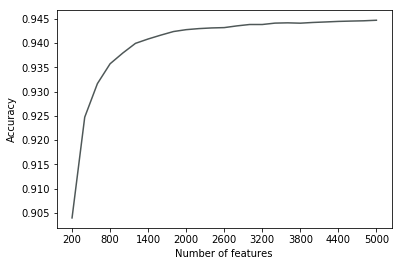

In [15]:
plt.plot(nfeatures_values, nfeatures_results, color='#4f5858')
plt.xticks(list(range(200, 5100, 600)))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

It seems that the more features we have the higher accuracy.

Choosing the most frequent features might not be optimal. Some frequent features will be useless because they don't provide any information about the target style. We can perform feature selection to choose a number of most useful features.

By passing *feature_selector* to the evaluation function we make sure the best features are selected in the training phase. In this case, the selection is done using feature importance scores from Random Forest.

Similarly as before, we will test this with varying number of chosen features:

In [16]:
nfeatures_results_rf = []
nfeatures_values = range(200, 5100, 200)
for n in nfeatures_values:
    accuracies, _ = evaluate_cv(dataset, LogisticRegression(solver='liblinear',
                                                            multi_class='ovr',
                                                            random_state=0),
                                feature_fun=get_tfidf_features,
                                feature_selector=select_features_rf,
                                nfeatures=n, ngrams=(2, 4), random_state=0)
    nfeatures_results_rf.append(mean(accuracies))
    print('Accuracy for {} features: {}'.format(n, mean(accuracies)))

Accuracy for 200 features: 0.8735980168069515
Accuracy for 400 features: 0.9242263212703586
Accuracy for 600 features: 0.9330316280900628
Accuracy for 800 features: 0.934897011154997
Accuracy for 1000 features: 0.9350237268786102
Accuracy for 1200 features: 0.9353665560923784
Accuracy for 1400 features: 0.9357557083898407
Accuracy for 1600 features: 0.9360051408540927
Accuracy for 1800 features: 0.9363129924117982
Accuracy for 2000 features: 0.9366535980195483
Accuracy for 2200 features: 0.9367814941402482
Accuracy for 2400 features: 0.9370428598831635
Accuracy for 2600 features: 0.9375889545319572
Accuracy for 2800 features: 0.9376458206287409
Accuracy for 3000 features: 0.9379186776905049
Accuracy for 3200 features: 0.9380567399882664
Accuracy for 3400 features: 0.9382041662216303
Accuracy for 3600 features: 0.9382147782649861
Accuracy for 3800 features: 0.9381471018052694
Accuracy for 4000 features: 0.9382502093147583
Accuracy for 4200 features: 0.9383524583301591
Accuracy for 4400 

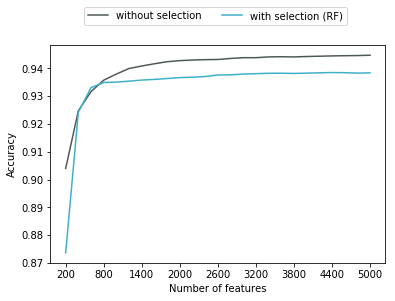

In [17]:
plt.plot(nfeatures_values, nfeatures_results, color='#4f5858')
plt.plot(nfeatures_values, nfeatures_results_rf, color='#3eb1c8')
plt.legend(['without selection', 'with selection (RF)'], bbox_to_anchor=(0.9, 1.2), ncol=3)
plt.xticks(list(range(200, 5100, 600)))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

We can see that in a small range RF selection results in slightly better performance, but as we increase the number of features, no selection outperforms RF-based selection.

We will also try a simpler selection method, based on chi-squared correlations:

In [18]:
nfeatures_results_chi2 = []
nfeatures_values = range(200, 5100, 200)
for n in nfeatures_values:
    accuracies, _ = evaluate_cv(dataset, LogisticRegression(solver='liblinear',
                                                            multi_class='ovr',
                                                            random_state=0),
                                feature_fun=get_tfidf_features,
                                feature_selector=select_features_chi2,
                                nfeatures=n, ngrams=(2, 4), random_state=0)
    nfeatures_results_chi2.append(mean(accuracies))
    print('Accuracy for {} features: {}'.format(n, mean(accuracies)))

Accuracy for 200 features: 0.835077284319014
Accuracy for 400 features: 0.8836485620181334
Accuracy for 600 features: 0.9027987668013104
Accuracy for 800 features: 0.9307199732572966
Accuracy for 1000 features: 0.9361420444884693
Accuracy for 1200 features: 0.9378643092801042
Accuracy for 1400 features: 0.9394137955831798
Accuracy for 1600 features: 0.9398904369576815
Accuracy for 1800 features: 0.9410076571799371
Accuracy for 2000 features: 0.9413842087264808
Accuracy for 2200 features: 0.9419310984404216
Accuracy for 2400 features: 0.942431638408049
Accuracy for 2600 features: 0.9427160326252992
Accuracy for 2800 features: 0.9430241968395998
Accuracy for 3000 features: 0.943274612166231
Accuracy for 3200 features: 0.943526407459392
Accuracy for 3400 features: 0.9438893176615941
Accuracy for 3600 features: 0.944208027533121
Accuracy for 3800 features: 0.9442528281900073
Accuracy for 4000 features: 0.9443788913826607
Accuracy for 4200 features: 0.9445043360918672
Accuracy for 4400 feat

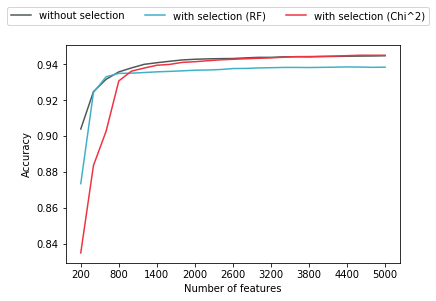

In [19]:
plt.plot(nfeatures_values, nfeatures_results, color='#4f5858')
plt.plot(nfeatures_values, nfeatures_results_rf, color='#3eb1c8')
plt.plot(nfeatures_values, nfeatures_results_chi2, color='#ef3340')
plt.legend(['without selection', 'with selection (RF)', 'with selection (Chi^2)'],
           bbox_to_anchor=(1.1, 1.2), ncol=3)
plt.xticks(list(range(200, 5100, 600)))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

The best accuracy resulted from chi-squared selection with 4600 features. We will use that from now on.

Let's also add one more feature (string length) to our feature representation. `get_features` function calculates TF-IDF features according to other parameters and adds string length to the feature vectors.

In [20]:
accuracies, _ = evaluate_cv(dataset, LogisticRegression(solver='liblinear',
                                                        multi_class='ovr',
                                                        random_state=0),
                            feature_fun=get_features,
                            feature_selector=select_features_chi2,
                            nfeatures=4600, ngrams=(2, 4), random_state=0)
print('Fold accuracies: {}'.format(accuracies))
print('Mean accuracy: {}'.format(mean(accuracies)))

Fold accuracies: [0.9416771392665372, 0.9487428571428571, 0.9445980253878702, 0.9450906602805337, 0.9456639489138491]
Mean accuracy: 0.9451545261983294


## Model selection

Let's also test a few learning algorithms using previously chosen parameters:

In [21]:
algo_results = []
for name, algo in [('Naive Bayes', MultinomialNB()),
                   ('Logistic Regression', LogisticRegression(solver='liblinear',
                                                              multi_class='ovr',
                                                              random_state=0)),
                   ('Linear SVC', LinearSVC(random_state=0)),
                   ('Random Forest', RandomForestClassifier(n_estimators=200, max_depth=3,
                                                            random_state=0))]:
    accuracies, _ = evaluate_cv(dataset, algo, feature_fun=get_features,
                                feature_selector=select_features_chi2,
                                nfeatures=4600, ngrams=(2, 4), random_state=0)
    algo_results.extend([(name, fold, accuracy) for fold, accuracy in enumerate(accuracies)])
    print('Accuracy for {} algorithm {}'.format(name, mean(accuracies)))

Accuracy for Naive Bayes algorithm 0.9204147179932866
Accuracy for Logistic Regression algorithm 0.9451545261983294


/home/dtkaczyk/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dtkaczyk/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dtkaczyk/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dtkaczyk/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dtkaczyk/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Accuracy for Linear SVC algorithm 0.8813461057211595
Accuracy for Random Forest algorithm 0.8282766247394051


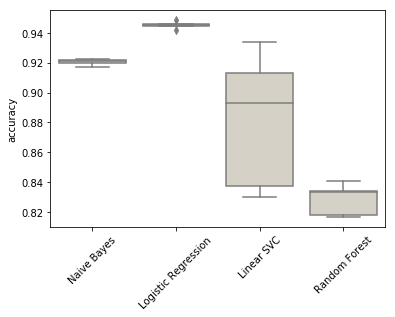

In [22]:
cv_df = pd.DataFrame(algo_results, columns=['model', 'fold', 'accuracy'])
ax = sns.boxplot(x='model', y='accuracy', data=cv_df, color="#d8d2c4")
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

It seems that logistic regression results in the best accuracy averaged over the folds. Also the variance of the results in this case is small.

## Final model

In [23]:
accuracies, dataset_results_cv = evaluate_cv(dataset,
                                             LogisticRegression(solver='liblinear',
                                                                multi_class='ovr',
                                                                random_state=0),
                                             feature_fun=get_features,
                                             feature_selector=select_features_chi2,
                                             nfeatures=4600, ngrams=(2, 4), random_state=0)
print('Fold accuracies: {}'.format(accuracies))
print('Mean accuracy: {}'.format(mean(accuracies)))

Fold accuracies: [0.9416771392665372, 0.9487428571428571, 0.9445980253878702, 0.9450906602805337, 0.9456639489138491]
Mean accuracy: 0.9451545261983294


Let's see the confusion matrix:

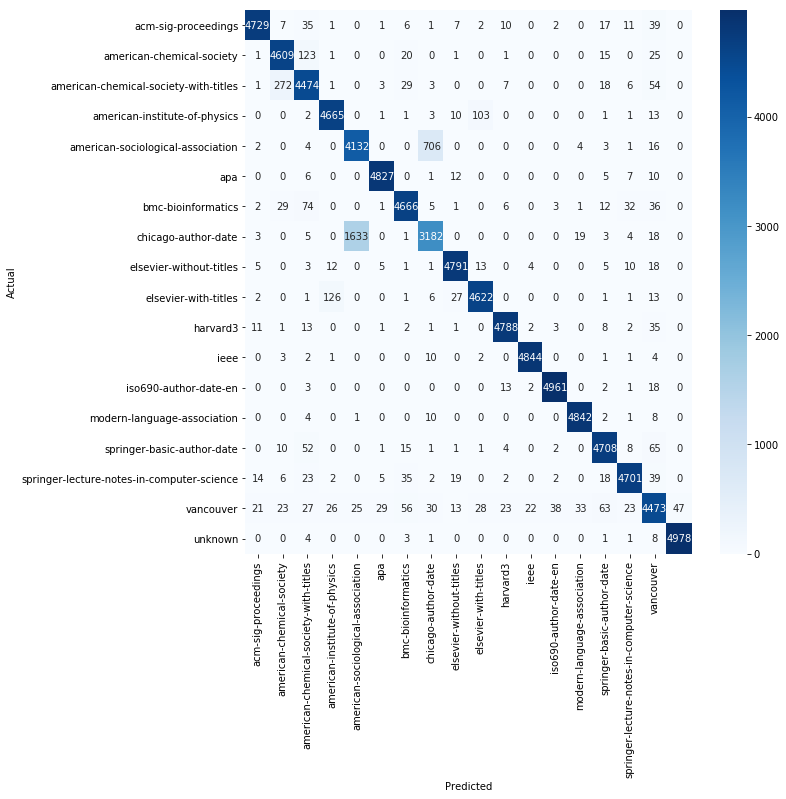

In [24]:
matrix = confusion_matrix(dataset_results_cv['style_true'], dataset_results_cv['style_pred'])

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=STYLES, yticklabels=STYLES + ['unknown'],
            cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Everything looks pretty good apart from the pair (chicago-author-date, american-sociological-association), which seem to be confused a lot by the classifier.

This function will show the reference string pairs from the two given  styles for all DOI that were mislabelled.

In [25]:
def get_diff(actual, predicted):
    diff_df = dataset_results_cv.loc[dataset_results_cv['style_true'] == actual]
    diff_dois = diff_df.loc[diff_df['style_pred'] == predicted]['doi']
    diff_df = dataset_results_cv.loc[dataset_results_cv['doi'].isin(diff_dois)]
    diff_df = diff_df.loc[diff_df['style_true'].isin([actual, predicted])].sort_values(by='doi')
    strings = [re.sub('^\(1\)', '', re.sub('^\[1\]', '',
                                           re.sub('^1', '', re.sub('\.$', '', s)))).strip()
               for s in diff_df['string']]
    strings_0 = [s for i, s in enumerate(strings) if i%2 == 0]
    strings_1 = [s for i, s in enumerate(strings) if i%2 == 1]
    return list(zip(strings_0, strings_1))

In [26]:
sample(get_diff('chicago-author-date', 'american-sociological-association'), 10)

[('Sridhar, S., R. Ravindra, and A. A. Khan. 2000. “Recovery of Monomethylhydrazine Liquid Propellant by Pervaporation Technique†.” Industrial & Engineering Chemistry Research 39 (7) : 2485–2490',
  'Sridhar, S., R. Ravindra, and A. A. Khan. 2000. “Recovery of Monomethylhydrazine Liquid Propellant by Pervaporation Technique†.” Industrial & Engineering Chemistry Research 39(7):2485–90'),
 ('Dawson, John M. 1985. “The Future of Space Plasma Simulation.” Space Science Reviews 42(1-2):187–208',
  'Dawson, John M. 1985. “The Future of Space Plasma Simulation.” Space Science Reviews 42 (1-2) : 187–208'),
 ('Bartos, G. 1969. “Einige Interessante Probleme Der Minimalisierung Der Elemente Einer Widerstandsdekade.” Tm - Technisches Messen 396-407 (JG)',
  'Bartos, G. 1969. “Einige Interessante Probleme Der Minimalisierung Der Elemente Einer Widerstandsdekade.” tm - Technisches Messen 396-407(JG)'),
 ('Morlova, Dumitru Daniel, and Corina Chiotan. 2015. “Monolithic Concrete Vs Precast Concrete for

In a lot of cases the reference strings are very similar, or identical. No wonder the classifier has problems differentiating between these styles.

## Test set evaluation

Finally, let's fit the model to the entire train set and evaluate on the main test set:

In [27]:
count_vectorizer, tfidf_transformer, train_features = \
    get_features(dataset['string'], dataset['style'], nfeatures=4600,
                 feature_selector=select_features_chi2, ngrams=(2, 4))
model = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0) \
        .fit(train_features, dataset['style'])

test_dataset = get_default_test_dataset()
test_dataset = clean_dataset(test_dataset)
test_dataset = add_noise(test_dataset, random_state=0)
dataset_unknown = generate_unknown(test_dataset, 5000, random_state=0)
test_dataset = pd.concat([test_dataset, dataset_unknown])

accuracy, _ = evaluate_model(test_dataset, count_vectorizer, tfidf_transformer, model)
print('The final accuracy: {}'.format(accuracy))

The final accuracy: 0.946681883024251


The final unbiased accuracy estimate is 94.7%.